In [1]:
from sklearn import preprocessing
import numpy as np
import joblib
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
import os
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LSTM
import tushare as ts
from tensorflow.keras.models import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional,Dropout,Conv1D,Masking,Input
from tensorflow import keras
from tensorflow.keras import layers,optimizers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
ts.set_token('4a09cc2e6745fc8d7873a94c8e034375bbb8ef00d12dcdcd078d5c9b')
pro = ts.pro_api()
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']
warnings.filterwarnings("ignore")

In [2]:
def mult_data_(dataset, target, start_index, history_size,target_size):
    data = []
    labels = []
    end_index = len(target) - history_size-target_size
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        data.append(dataset[i:history_size+i])
        labels.append(target[i+history_size:i+history_size +target_size])
    return np.array(data), np.array(labels)

新版 tushare

In [3]:
data = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

In [4]:
data[data['name'].str.contains('五粮液')]

,ts_code,symbol,name,area,industry,list_date
347,000858.SZ,000858,五粮液,四川,白酒,19980427


In [5]:
#data[data['symbol'] =='000533']
#data[data['symbol'] =='600519']
data[data['ts_code'] =='000858.SZ']

,ts_code,symbol,name,area,industry,list_date
347,000858.SZ,000858,五粮液,四川,白酒,19980427


In [6]:
data

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,国华网安,深圳,软件服务,19910114
3,000005.SZ,000005,ST星源,深圳,环境保护,19901210
4,000006.SZ,000006,深振业A,深圳,区域地产,19920427
...,...,...,...,...,...,...
4527,688819.SH,688819,天能股份,浙江,电气设备,20210118
4528,688981.SH,688981,中芯国际,上海,半导体,20200716
4529,834765.BJ,834765,美之高(测试),None,None,20210705
4530,836433.BJ,836433,大唐药业(测试),None,None,20211008


In [7]:
15 * 3600

54000

In [8]:
df = pro.query('daily', ts_code='000858.SZ', start_date='19940103',)
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000858.SZ,20211105,206.82,214.70,206.81,210.31,206.82,3.49,1.6875,301429.97,6.372245e+06
1,000858.SZ,20211104,201.09,207.86,200.30,206.82,199.13,7.69,3.8618,298641.62,6.104737e+06
2,000858.SZ,20211103,201.52,202.50,198.68,199.13,201.32,-2.19,-1.0878,218919.68,4.378799e+06
3,000858.SZ,20211102,203.98,205.90,199.65,201.32,204.94,-3.62,-1.7664,349334.47,7.067035e+06
4,000858.SZ,20211101,200.00,209.52,196.90,204.94,216.51,-11.57,-5.3439,580036.53,1.177576e+07
...,...,...,...,...,...,...,...,...,...,...,...
4995,000858.SZ,20000906,32.70,32.70,31.98,32.01,32.70,-0.69,-2.1100,9095.78,2.931080e+04
4996,000858.SZ,20000905,33.49,33.49,32.60,32.70,33.14,-0.44,-1.3300,6056.00,2.006845e+04
4997,000858.SZ,20000904,33.04,33.50,32.78,33.14,33.23,-0.09,-0.2700,6163.00,2.036327e+04
4998,000858.SZ,20000901,33.20,33.71,33.10,33.23,33.46,-0.23,-0.6900,9889.00,3.306969e+04


In [9]:
timespan = 2
test_span = 4500
data = df.loc[:,['open','high','close','low','pre_close','change','pct_chg']]
data = np.flipud(data) 
normalizer = preprocessing.MinMaxScaler()
X_ = normalizer.fit_transform(data)
Y_ =  np.flipud(df['close'].values)

In [10]:
X_train_,y_train_ =mult_data_(X_,Y_,0,30,timespan)
train_X = X_train_[0:test_span]
test_X = X_train_[test_span:]
train_y = y_train_[0:test_span]
test_y = y_train_[test_span:]
#模型
input_data = Input(shape=(train_X.shape[1],train_X.shape[2]))
x = Bidirectional(LSTM(units=32, return_sequences=True))(input_data)
x = LSTM(units=32, return_sequences=False)(x)
x = Dense(32)(x)
output = Dense(timespan)(x)
model = Model(input_data, output)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) 
adam = Adam(lr=1e-4)
model.compile(optimizer=rms,loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 7)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 64)            10240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 23,778
Trainable params: 23,778
Non-trainable params: 0
_________________________________________________________________


In [11]:
#训练
history = model.fit(X_train_,y_train_,  validation_data=(test_X,test_y),  epochs=40, batch_size=128)

Train on 4938 samples, validate on 438 samples
Epoch 1/40
4938/4938 [==============================] - 6s 1ms/sample - loss: 5719.9111 - val_loss: 48411.4946
Epoch 2/40
4480/4938 [==========================>...] - ETA: 0s - loss: 4863.3764

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(18, 6.5))
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))

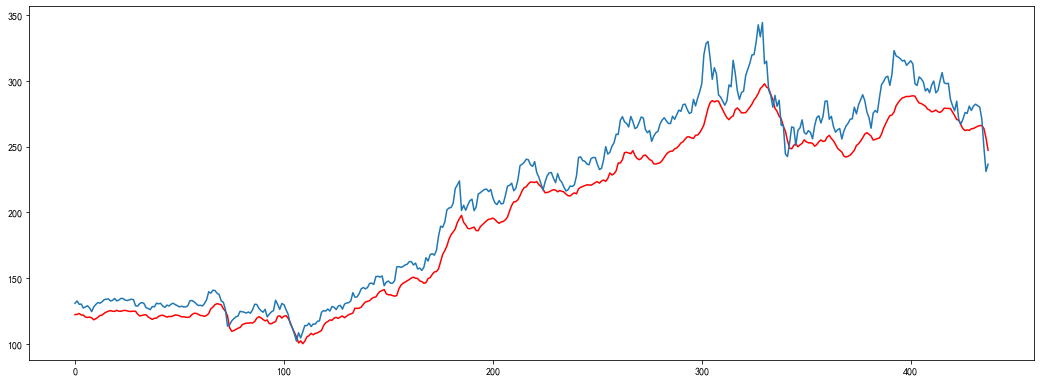

In [39]:
y_predict = model.predict(test_X)
plt.figure(figsize=(18, 6.5))
plt.plot((y_predict[:,0]),c='r')
plt.plot(test_y[:,0])

In [40]:
data = df.loc[:,['open','high','close','low','pre_close','change','pct_chg']]
data = np.flipud(data) 
data = normalizer.transform(data)
pre_data = np.array([data[-33:-3]])
y_predict = model.predict(pre_data)
y_predict

array([[247.2978 , 248.17062]], dtype=float32)

In [41]:
data = df.loc[:,['open','high','close','low','pre_close','change','pct_chg']]
data = np.flipud(data) 
data = normalizer.transform(data)
pre_data = np.array([data[-32:-2]])
y_predict = model.predict(pre_data)
y_predict

array([[241.88771, 242.82466]], dtype=float32)

In [42]:
data = df.loc[:,['open','high','close','low','pre_close','change','pct_chg']]
data = np.flipud(data) 
data = normalizer.transform(data)
pre_data = np.array([data[-31:-1]])
y_predict = model.predict(pre_data)
y_predict

array([[238.4919, 239.4655]], dtype=float32)

In [43]:
data = df.loc[:,['open','high','close','low','pre_close','change','pct_chg']]
data = np.flipud(data) 
data = normalizer.transform(data)
pre_data = np.array([data[-30:]])
y_predict = model.predict(pre_data)
y_predict

array([[231.79176, 232.82307]], dtype=float32)

In [44]:
220.75

220.75